In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats
import math

In [2]:
cd CSVs

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1/CSVs


#### Load Data

In [3]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])
data
data.DESC.value_counts()

REGULAR       2240973
RECOVR AUD       9835
Name: DESC, dtype: int64

### Clean Data

remove spaces from column names

In [4]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [5]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [6]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

Only look at regular data

In [7]:
data = data[data.DESC == 'REGULAR']
data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,00:00:00,REGULAR,7053483,2390505,2019-05-11 00:00:00,A002R05102-00-0059 ST,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday


#### Find total traffic

Add shifted columns to show previous entries and exits

In [8]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data.copy()
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
grouped_time.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,05:00:00,REGULAR,5554,376,2019-05-03 05:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,01:00:00,376.0,5554.0
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,09:00:00,REGULAR,5554,376,2019-05-03 09:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,05:00:00,376.0,5554.0
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,13:00:00,REGULAR,5554,376,2019-05-03 13:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,09:00:00,376.0,5554.0
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,17:00:00,REGULAR,5554,376,2019-05-03 17:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,13:00:00,376.0,5554.0
206856,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-05-03,21:00:00,REGULAR,5554,376,2019-05-03 21:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,17:00:00,376.0,5554.0


In [9]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True)
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0


Remove counter errors from total entries/exits that occur from counters resetting

In [10]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter_ex = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter_ent = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [11]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=100000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=100000)
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS
count,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06,2.236073e+06
mean,4.148039e+07,3.396750e+07,3.396821e+07,4.148122e+07,6.120600e+02,4.912548e+02
std,2.118498e+08,1.951475e+08,1.951484e+08,2.118507e+08,4.711624e+03,4.015928e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.499730e+05,1.430240e+05,1.430260e+05,3.499680e+05,1.000000e+01,9.000000e+00
50%,2.176565e+06,1.254667e+06,1.254664e+06,2.176577e+06,7.600000e+01,5.500000e+01
75%,6.780894e+06,4.604451e+06,4.604462e+06,6.780916e+06,2.520000e+02,1.760000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,9.997500e+04,9.999600e+04


In [12]:
#find total traffic
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [13]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering
grouped_time.describe()

,ENTRIES,EXITS,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
count,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06,2.212235e+06
mean,4.145657e+07,3.392900e+07,3.393014e+07,4.145877e+07,2.111534e+02,1.666225e+02,3.777759e+02
std,2.117360e+08,1.950153e+08,1.950168e+08,2.117418e+08,6.844930e+02,5.832379e+02,1.089409e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.461120e+05,1.405950e+05,1.405980e+05,3.462060e+05,1.000000e+01,8.000000e+00,2.900000e+01
50%,2.166457e+06,1.246360e+06,1.246475e+06,2.166594e+06,7.400000e+01,5.300000e+01,1.740000e+02
75%,6.771164e+06,4.591253e+06,4.591504e+06,6.771260e+06,2.440000e+02,1.700000e+02,4.640000e+02
max,2.129395e+09,2.124196e+09,2.124196e+09,2.129395e+09,2.481100e+04,2.474800e+04,2.482000e+04


drop uneeded columns

In [14]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME','DESC', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS', 'TOTAL_ENTRIES', 'TOTAL_EXITS'], axis=1, inplace=True)

In [15]:
#grouped_day = data.groupby(['DATE','Turnstile','STATION'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = data.groupby(['STATION','DATE']).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = grouped.set_index('STATION')
#grouped.head()

In [16]:
#grouped_day.head()

In [17]:
#grouped.columns = [ 'Station', 'Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped_day.columns = [ 'Date', 'Turnstile', 'Station','ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.columns = ['ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.dtypes

Find total entries exits, and traffic

In [18]:
#grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
#grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
#grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Entries']
#grouped_day.head()

In [19]:
#grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)



Removing Outlier data from Total_traffic column (Removing anything outside 3 sigma)

In [20]:
#grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

#### Combine data

### Finding top 10 visited stations

In [21]:
Total_ridership = grouped_day.groupby(['Station']).Total_Traffic.sum().reset_index()

NameError: name 'grouped_day' is not defined

In [ ]:
Total_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)


In [ ]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.Total_Traffic 
    station_list = rows.Station
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(10)


In [ ]:
plt.ylim(10000000,21000000)
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.title("Total traffic for the period for top 10 busiest stations")
plt.bar(indices, Row_list)

Top 10 Busy Stations, We will focus on top5 of these.

In [ ]:
indices

### Find high traffic days

In [ ]:
Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.sum().reset_index()
#Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.mean().reset_index()
Total_Weekly_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)
Total_Weekly_ridership.head()

In [ ]:
#plt.ylim(1610000000000,1620000000000)
plt.ylim(40000000,140000000)
plt.bar(Total_Weekly_ridership['Week_Day'], Total_Weekly_ridership['Total_Traffic'])

Based on this it seems like weekends see much less traffic compared to weekdays. So WWTF should focus more on weekdays 

In [ ]:
Top5 = Total_ridership['Station'][0:5].tolist()
Top5_stations = grouped_day[grouped_day['Station'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['Station','Date']).Total_Traffic.sum().reset_index()
#Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.mean().reset_index()

#### Weekly Plot for Top5 stations

In [ ]:

for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
    plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()



Looking at the plot seems like top5 stations are also showing a dip on weekends, but PATH NEW WTC station is oblitrating seeing the trend properly. This needs to be investigated further. Also, to see the trend for rest of the station we will do another plot removing the data for PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
        plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This is also showing the dip in weekend more clearly. But GRD CNTRL-42 ST shows peak on thursday - which needs to be investigated.

In [ ]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
    plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot is also showing some abnormal values for some of the days for PATH NEW WTC. Two of these dates are looking on thursdays. We will look at rest of the stations removing PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
        plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot also seems to have some outliers. But In general trend is clear Traffic takes a dip on weekends and remains kind of static on weekdays

### Find peak hours

### Find high traffic areas for games

### Compare Boroughs

read location data to get borough info and latitude/longitude information

In [82]:
loc_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
#print(loc_data.Borough.unique())
loc_df.tail()
print(loc_df[loc_df['GTFS Latitude']== 40.750580])


Empty DataFrame
Columns: [Station ID, Complex ID, GTFS Stop ID, Division, Line, Stop Name, Borough, Daytime Routes, Structure, GTFS Latitude, GTFS Longitude, North Direction Label, South Direction Label, ADA, ADA Notes]
Index: []


In [83]:
#add borough_name column
burough_dict = { 'Q': 'Queens', 'M': 'Manhattan', 'Bk':'Brooklyn', 'Bx': 'Bronx', 'SI': 'Staten Island'}
loc_df['Borough_Name'] = loc_df['Borough'].map(burough_dict)

In [84]:
#drop uneeded columns
loc_df.drop(['Borough','Line','Station ID','Complex ID', 'GTFS Stop ID', 'Line', 'Structure', 
               'Daytime Routes', 'North Direction Label', 'South Direction Label', 'ADA', 'ADA Notes'], axis=1, inplace =True)

Rename columns in loc_data to merge on STATION and DIVISION

In [105]:
#stations were found to have the same but located in diff areas so DIVISION was also used
loc_df.rename(columns = {'Stop Name':'STATION', 'Division':'DIVISION','GTFS Latitude':'Latitude','GTFS Longitude':'Longitude'}, inplace = True) 
loc_df['STATION'] = loc_df['STATION'].str.upper()
loc_df['STATION'] = loc_df['STATION'].str.replace('STATION', 'STA')
loc_df['STATION'] = loc_df['STATION'].str.replace('GRAND CENTRAL', 'GRD CNTRL')
loc_df['STATION'] = loc_df['STATION'].str.replace('42 ST-PORT AUTHORITY BUS TERMINAL', '42 ST-PORT AUTH')
#join with grouped_time
station_loc_df = grouped_time.merge(loc_df, how = 'inner', on = ['STATION'])
station_loc_df.tail()
print(station_loc_df[station_loc_df['STATION']=='28 ST'])
print(station_loc_df[station_loc_df['STATION']=='34 ST-PENN STA'])

       STATION DIVISION_x       DATE      TIME           Date_Time  \
213514   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
213515   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
213516   28 ST        BMT 2019-05-11  04:00:00 2019-05-11 04:00:00   
213517   28 ST        BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
213518   28 ST        BMT 2019-05-11  08:00:00 2019-05-11 08:00:00   
...        ...        ...        ...       ...                 ...   
266915   28 ST        IRT 2019-05-03  17:00:00 2019-05-03 17:00:00   
266916   28 ST        IRT 2019-05-03  17:00:00 2019-05-03 17:00:00   
266917   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   
266918   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   
266919   28 ST        IRT 2019-05-03  21:00:00 2019-05-03 21:00:00   

                    Turnstile  Week_Day  TOTAL_TRAFFIC DIVISION_y   Latitude  \
213514  A027R08201-00-0028 ST  Saturday           87.0        BMT  40.745494   

#### Graph number of stations in each borough

<BarContainer object of 5 artists>

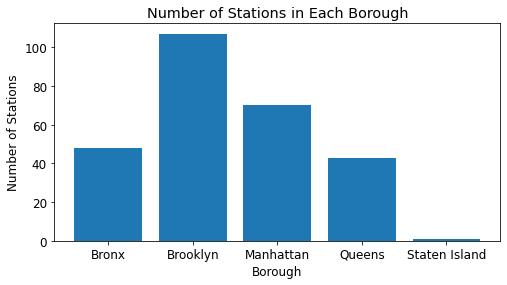

In [106]:
borough_station_count_df = station_loc_df.groupby('Borough_Name')['STATION'].nunique().reset_index()
#borough_station_count_df
plt.rcParams["figure.figsize"] = (8, 4)
plt.xlabel("Borough")
plt.ylabel("Number of Stations")
plt.title("Number of Stations in Each Borough")
plt.bar(borough_station_count_df['Borough_Name'], borough_station_count_df['STATION'])

#### Graph total traffic in each Borough 

<BarContainer object of 5 artists>

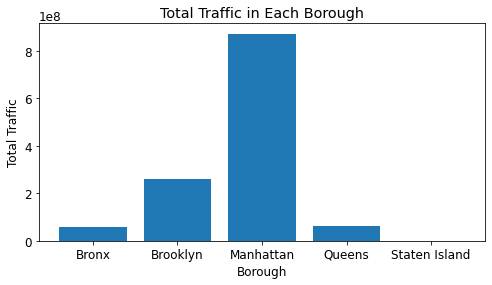

In [107]:
borough_traffic_df = station_loc_df.groupby('Borough_Name').TOTAL_TRAFFIC.sum().reset_index()
plt.xlabel("Borough")
plt.ylabel("Total Traffic")
plt.title("Total Traffic in Each Borough")
plt.bar(borough_traffic_df['Borough_Name'], borough_traffic_df['TOTAL_TRAFFIC'])
#borough_traffic_df

### Find top stations in each borough

#### Find top 5 stations in each borough and graph

In [108]:
borough_top5_df = station_loc_df.groupby(['Borough_Name','STATION']).agg({'TOTAL_TRAFFIC':'sum'})
borough_top5_df = borough_top5_df['TOTAL_TRAFFIC'].groupby('Borough_Name', group_keys=False)
borough_top5_df = borough_top5_df.apply(lambda x: x.sort_values(ascending=False).head(5))
borough_top5_df

Borough_Name   STATION        
Bronx          FORDHAM RD          5020206.0
               167 ST              4645166.0
               KINGSBRIDGE RD      4505952.0
               170 ST              4130198.0
               GUN HILL RD         3450604.0
Brooklyn       86 ST              25797912.0
               CHURCH AV          15777033.0
               FULTON ST          14657662.0
               KINGS HWY          12601506.0
               7 AV               10612046.0
Manhattan      23 ST              70800200.0
               CANAL ST           65664786.0
               GRD CNTRL-42 ST    60331374.0
               FULTON ST          58630648.0
               TIMES SQ-42 ST     55958712.0
Queens         111 ST              6122097.0
               WOODHAVEN BLVD      6089928.0
               COURT SQ            5935204.0
               36 ST               2846419.0
               JUNCTION BLVD       2838276.0
Staten Island  TOMPKINSVILLE        247600.0
Name: TOTAL_TRAFFIC, dty

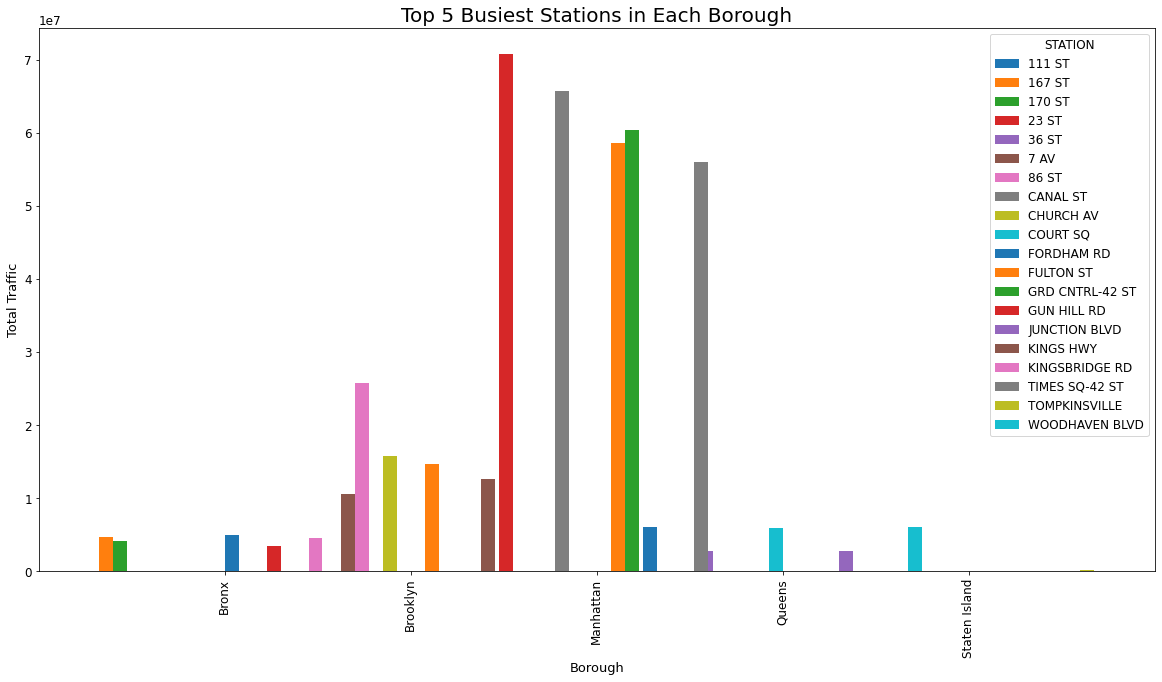

In [109]:
rcParams['figure.figsize'] = 20,10
borough_top5_df.unstack().plot.bar(width=1.5)
#plt.bar([0,2,3,4],borough_top5_df.unstack(),width=1.5)
#plt.bar(borough_top5_df.unstack(),width=1.5)
plt.title("Top 5 Busiest Stations in Each Borough", fontsize=20)
plt.ylabel("Total Traffic",fontsize=13)
plt.xlabel("Borough",fontsize=13)
plt.rcParams.update({'font.size': 9})
#plt.tight_layout()
 
#borough_top5_df.unstack().plot.bar()

### Find stations in the highest income areas

In [110]:
#import income data
income_data = pd.read_csv('https://raw.githubusercontent.com/hollyyuqizheng/transportation-transformation/master/data/new_york/new%20york%20income%20data.csv')
#print(loc_data.Borough.unique())
income_data.head()

,Zip Code,Location,City,Avg. Income/H/hold,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,10007,"40.713973, -74.008336","New York, New York",112947,NaN,NaN,NaN
1,10280,"40.708501, -74.016828","New York, New York",108536,NaN,NaN,NaN
2,10162,"40.769298, -73.949942","New York, New York",108416,NaN,NaN,NaN
3,10004,"40.691870, -74.014109","New York, New York",101868,NaN,NaN,NaN
4,10069,"40.775551, -73.989689","New York, New York",88091,NaN,NaN,NaN


In [111]:
#new df grouped by latitude, longitude, and station
#station_lat_long_df = station_loc_df.groupby(['STATION','Borough_Name'], as_index=False ).agg({'Latitude':'mean','Longitude':'mean','TOTAL_TRAFFIC':'count'})
station_lat_long_df = station_loc_df.groupby(['Latitude','Longitude', 'STATION','Borough_Name'], as_index=False ).TOTAL_TRAFFIC.sum()
station_lat_long_df.drop_duplicates('STATION',keep='first', inplace=True)
#print(station_lat_long_df[station_lat_long_df['STATION']=='28 ST'])

#station_lat_long_df.duplicated(subset=['STATION']) 
#print(station_lat_long_df[station_lat_long_df['STATION']==True])

Find average income for each station

In [112]:
#row from station_income_df as argument
#loop through income_df to find closest zip code based on latitude and longitude
#return Avg income of closest zip code to station
def find_min_dist(row):
    min_dist = 1000
    idx = 0
    for index, r in income_data.iterrows():
        l = r[1].split(", ")
        l = [float(i) for i in l]
        a = ((l[0] - row['Latitude'])**2 + (l[1] - row['Longitude'])**2)
        a = abs(a)
        dist = math.sqrt(a)
        if dist < min_dist:
            min_dist = dist
            idx = index
    return income_data.iloc[idx]['Avg. Income/H/hold']

In [113]:
station_income_df = station_lat_long_df.copy()
station_income_df['Avg_Income'] = station_income_df.apply(find_min_dist, axis=1)
station_income_df.sort_values('Avg_Income', ascending=False, inplace=True)
station_income_df['Avg_Income'] = station_income_df['Avg_Income']/1000
#station_income_df['Rank_Income'] = station_income_df['Avg_Income'].rank(method='dense')
#station_income_df.head(10)
total_income = station_income_df['Avg_Income'].sum()
station_income_df.duplicated(subset=['STATION']) 
print(station_income_df)

      Latitude  Longitude          STATION Borough_Name  TOTAL_TRAFFIC  \
257  40.764811 -73.973347       5 AV/59 ST    Manhattan      2166735.0   
248  40.759901 -73.984139            49 ST    Manhattan      3338006.0   
230  40.750373 -73.991057   34 ST-PENN STA    Manhattan     23461003.0   
227  40.749567 -73.987950  34 ST-HERALD SQ    Manhattan     16776171.0   
145  40.706476 -74.011056         BROAD ST    Manhattan      1257782.0   
..         ...        ...              ...          ...            ...   
301  40.830135 -73.938209           155 ST    Manhattan      1021278.0   
292  40.820421 -73.936245           145 ST    Manhattan      4792705.0   
280  40.805368 -73.914042       CYPRESS AV        Bronx       638661.0   
281  40.807566 -73.919240         BROOK AV        Bronx      1013783.0   
161  40.710668 -74.011029     CORTLANDT ST    Manhattan      4060938.0   

     Avg_Income  
257    9925.825  
248    1920.137  
230     775.718  
227     775.718  
145     683.269  
.. 

In [114]:
top_traffic_stations_df = station_income_df.copy()
top_traffic_stations_df = top_traffic_stations_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']]
top_traffic_stations_df.sort_values('TOTAL_TRAFFIC', ascending=False, inplace=True)
#top_traffic_stations_df['Rank_Traffic'] = top_traffic_stations_df['TOTAL_TRAFFIC'].rank(method='dense')
#top_traffic_stations_df['Avg_Income'] = top_traffic_stations_df['Avg_Income']/1000
top_traffic_stations_df['TOTAL_TRAFFIC'] = top_traffic_stations_df['TOTAL_TRAFFIC']/1000000
top10_traffic_stations_df = top_traffic_stations_df.head(10)
#print(top_station_income_df )
print(top_traffic_stations_df )
print(station_income_df )
total_traffic = top_traffic_stations_df['TOTAL_TRAFFIC'].sum()
print(total_traffic )

      Borough_Name          STATION  Avg_Income  TOTAL_TRAFFIC
230      Manhattan   34 ST-PENN STA     775.718      23.461003
231      Manhattan  GRD CNTRL-42 ST     122.802      20.110458
227      Manhattan  34 ST-HERALD SQ     775.718      16.776171
114       Brooklyn        FULTON ST      49.567      14.657662
205      Manhattan            23 ST      62.467      14.160040
..             ...              ...         ...            ...
2         Brooklyn       NEPTUNE AV      21.281       0.307780
4           Queens      BEACH 98 ST      57.443       0.274311
50   Staten Island    TOMPKINSVILLE      45.620       0.247600
3           Queens     BEACH 105 ST      57.443       0.165250
25          Queens    BROAD CHANNEL      57.443       0.120142

[256 rows x 4 columns]
      Latitude  Longitude          STATION Borough_Name  TOTAL_TRAFFIC  \
257  40.764811 -73.973347       5 AV/59 ST    Manhattan      2166735.0   
248  40.759901 -73.984139            49 ST    Manhattan      3338006.0  

In [115]:
top50_income = station_income_df.head(50)
top50_income['Rank_Income'] = top50_income['Avg_Income'].rank(method='dense')
top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100

top50_traffic = top_traffic_stations_df.head(50)
top50_traffic['Rank_Traffic'] = top50_traffic['TOTAL_TRAFFIC'].rank(method='dense')
top50_traffic['Traffic_Percentile'] = (top50_traffic['TOTAL_TRAFFIC']/total_traffic)*100

top50_income.drop([ 'Avg_Income'], axis=1, inplace=True)
top50_traffic.drop([ 'Avg_Income'], axis=1, inplace=True)

<ipython-input-115-67a3123556de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_income['Rank_Income'] = top50_income['Avg_Income'].rank(method='dense')
<ipython-input-115-67a3123556de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top50_income['Income_Percentile'] = (top50_income['Avg_Income']/total_income)*100
<ipython-input-115-67a3123556de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [116]:
top_50_df = top50_income.merge(top50_traffic, how = 'inner', on = ['STATION', 'Borough_Name'])
top_50_df['Total_Rank'] = top_50_df['Rank_Income'] + top_50_df['Rank_Traffic']
top_50_df['Total_Percentile'] = top_50_df['Traffic_Percentile'] + top_50_df['Income_Percentile']
top_50_df.sort_values('Total_Percentile', ascending=False, inplace=True)
top10_rank_df = top_50_df.head(10)
print(top_50_df)

     Latitude  Longitude          STATION Borough_Name  TOTAL_TRAFFIC_x  \
0   40.759901 -73.984139            49 ST    Manhattan        3338006.0   
1   40.750373 -73.991057   34 ST-PENN STA    Manhattan       23461003.0   
2   40.749567 -73.987950  34 ST-HERALD SQ    Manhattan       16776171.0   
5   40.751431 -73.976041  GRD CNTRL-42 ST    Manhattan       20110458.0   
16  40.739864 -73.986599            23 ST    Manhattan       14160040.0   
20  40.734673 -73.989951   14 ST-UNION SQ    Manhattan       13962090.0   
7   40.718092 -73.999892         CANAL ST    Manhattan       10944131.0   
14  40.732338 -74.000495   W 4 ST-WASH SQ    Manhattan       11849174.0   
6   40.713243 -74.003401      CHAMBERS ST    Manhattan        8605351.0   
18  40.737826 -74.000201            14 ST    Manhattan        9047249.0   
12  40.784318 -73.947152            96 ST    Manhattan        8497078.0   
10  40.706821 -74.009100          WALL ST    Manhattan        6926455.0   
17  40.743070 -73.984264 

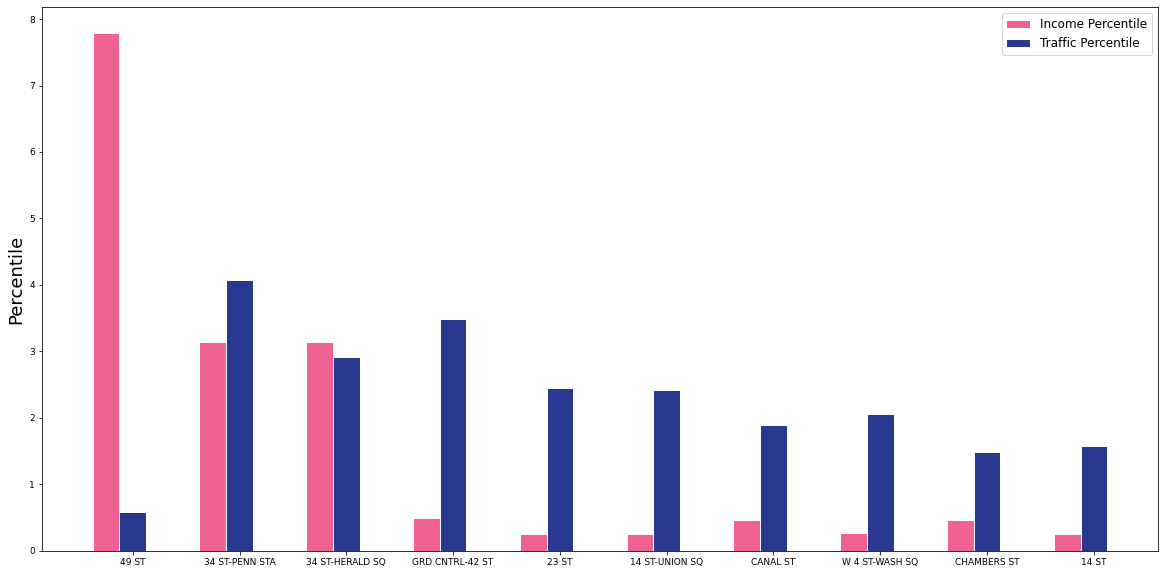

In [117]:
barWidth = 0.25
 
# set height of bar
#bars1 = [12, 30, 1, 8, 22]
#bars2 = [28, 6, 16, 5, 10]
#bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(top10_rank_df['Rank_Income']))
r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1,top10_rank_df['Income_Percentile'], color= '#f06292', width=barWidth, edgecolor='white', label='Income Percentile')
plt.bar(r2, top10_rank_df['Traffic_Percentile'], color='#2a3990', width=barWidth, edgecolor='white', label='Traffic Percentile')
#plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label='var3')
plt.ylabel("Percentile",fontsize=18)
# Add xticks on the middle of the group bars
#plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(top10_rank_df['Rank_Income']))], top10_rank_df['STATION'])
 
plt.rcParams['font.size']= 12
plt.legend()
plt.savefig('top10_rank_bar.png', dpi=300)
plt.show()

#plt.ylabel("Rank",fontsize=18)
#plt.title("Top 10 Stations with Highest Incomes",fontsize=27)





(0.0, 90.0)

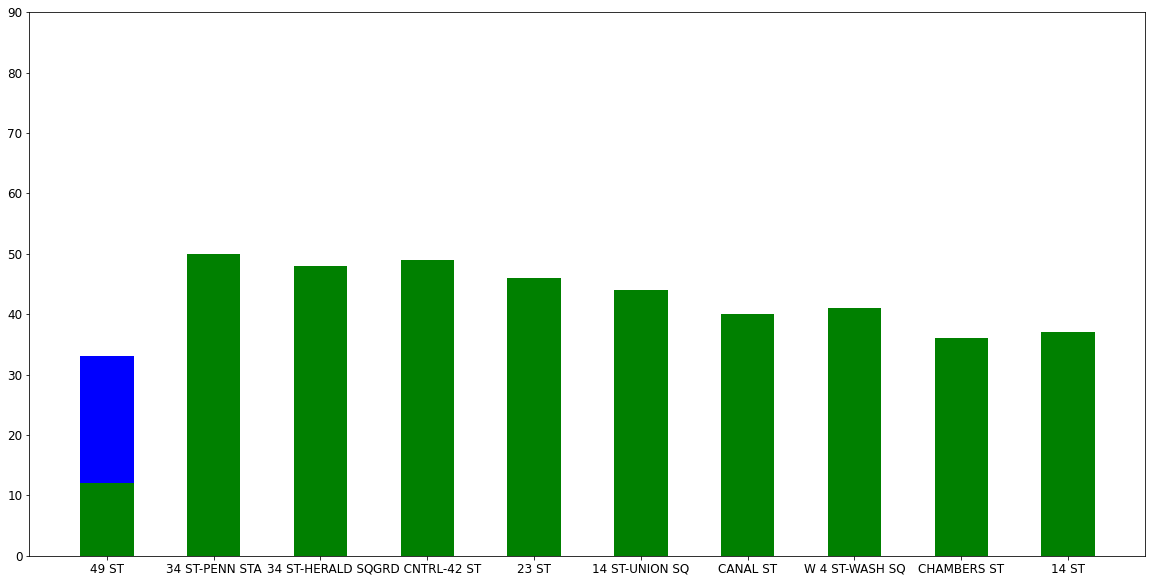

In [118]:
top10_rank_df = top_50_df.head(10)
ax = plt.subplot(111)
ax.bar(top10_rank_df['STATION'], top10_rank_df['Rank_Income'], width=0.5, color='b', align='center')
ax.bar(top10_rank_df['STATION'], top10_rank_df['Rank_Traffic'], width=0.5, color='g', align='center')
plt.ylim(0, 90)

In [119]:
cd-

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1


In [120]:
cd Graphs

/Users/racheldilley/Documents/Metis/git_repos/mta-project-1/Graphs


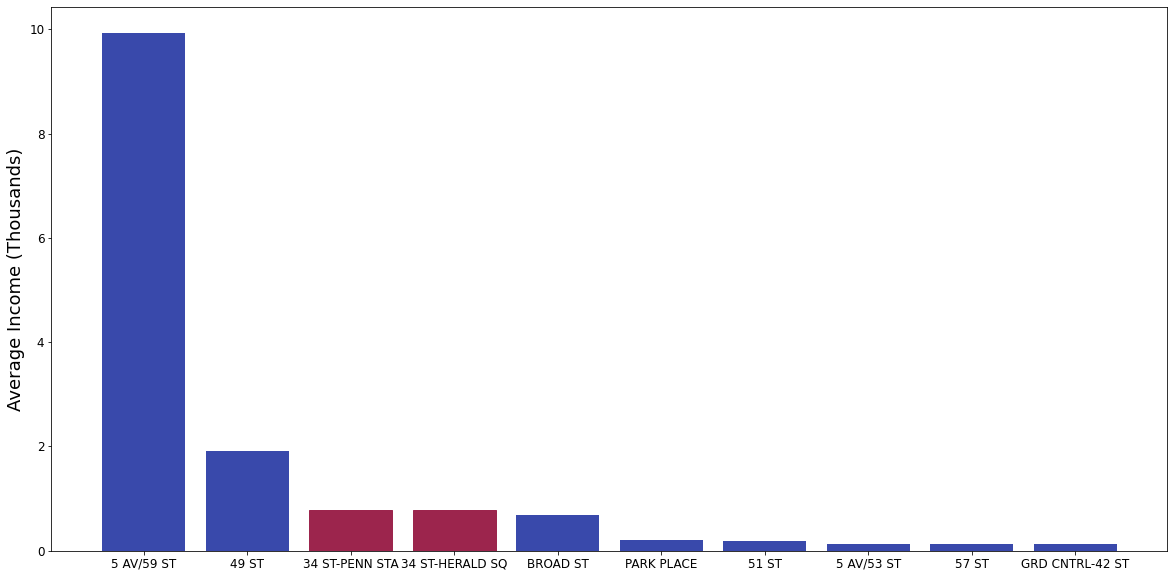

In [121]:
plt.rcParams['font.size']= 12
top_station_income_df = station_income_df[['Borough_Name','STATION','Avg_Income', 'TOTAL_TRAFFIC']].head(10)
top_station_income_df['Avg_Income'] = top_station_income_df['Avg_Income']/1000
top_station_income_df['TOTAL_TRAFFIC'] = top_station_income_df['TOTAL_TRAFFIC']/1000000

top_inc_bar = plt.bar(top_station_income_df['STATION'], top_station_income_df['Avg_Income'], color='#3949ab')
plt.ylabel("Average Income (Thousands)",fontsize=18)

top_inc_bar[3].set_color('#9c254d')
top_inc_bar[2].set_color('#9c254d')
top_inc_bar[2].set_color('#9c254d')
#top_inc_bar[8].set_color('mediumorchid')
plt.savefig('top10_inc_bar.png', dpi=300)
plt.show()

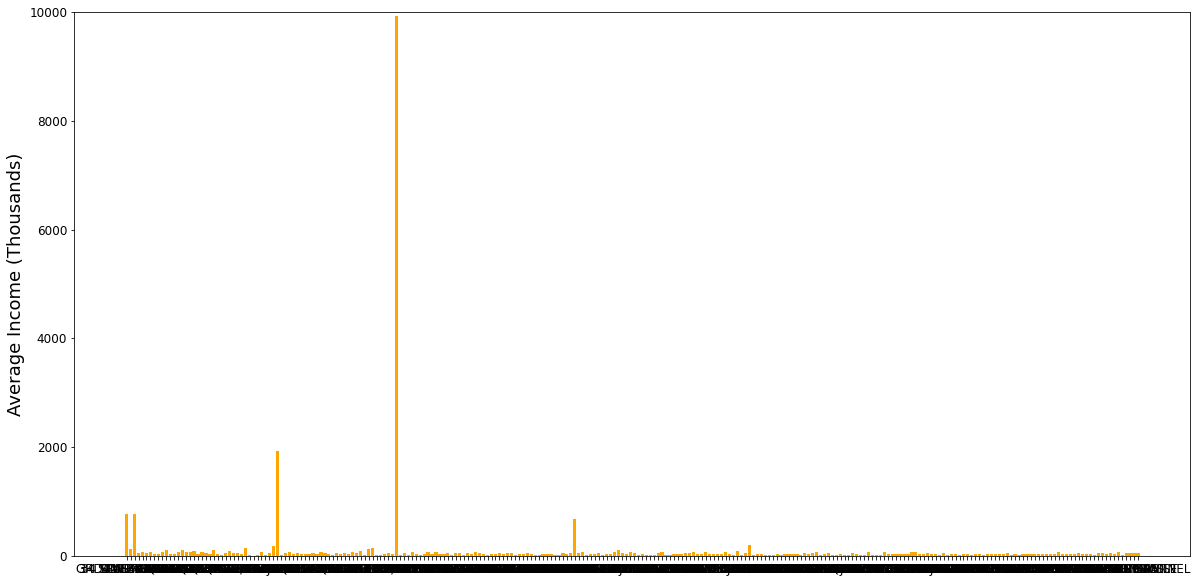

In [122]:
top10_traf_inc_bar = plt.bar(top_traffic_stations_df['STATION'], top_traffic_stations_df['Avg_Income'],color='orange')
#plt.xlabel("Stations",fontsize=18)
plt.ylabel("Average Income (Thousands)",fontsize=18)
#plt.title("Incomes of Top 10 Stations with Highest Traffic",fontsize=27)
plt.ylim(0, 10000)
top_traf_inc_bar[0].set_color('b')
top_traf_inc_bar[1].set_color('b')
top_traf_inc_bar[7].set_color('mediumorchid')
plt.savefig('top10_inc_traf_bar.png', dpi=300)

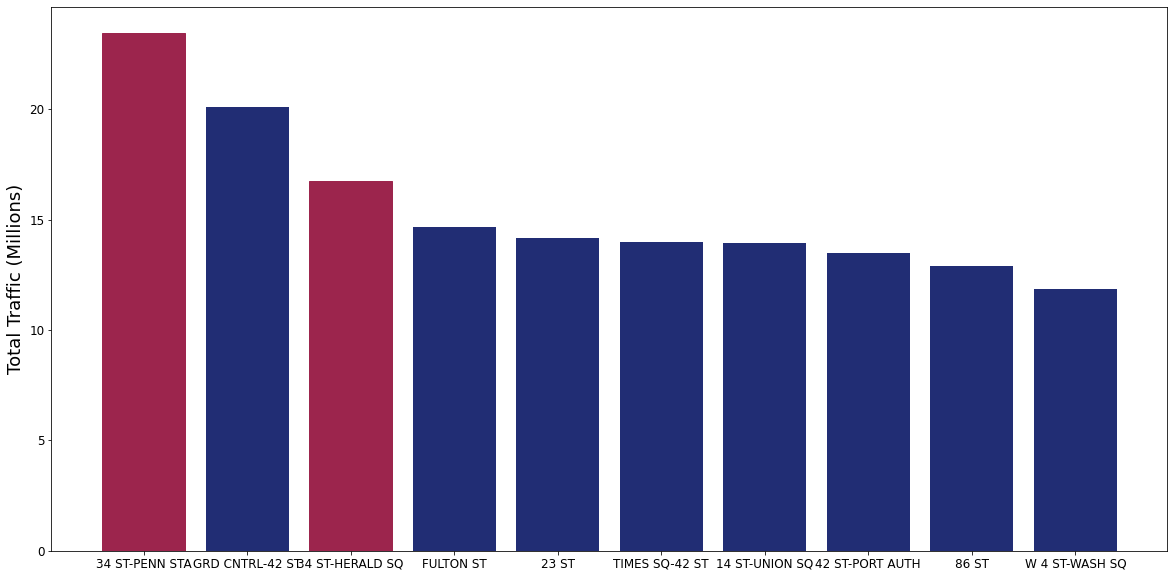

In [123]:
top10_traf_bar = plt.bar(top10_traffic_stations_df['STATION'], top10_traffic_stations_df['TOTAL_TRAFFIC'],color='#212d74')
#plt.xlabel("Stations",fontsize=18)
plt.ylabel("Total Traffic (Millions)",fontsize=18)
#plt.title("Top 10 Stations with Highest Traffic",fontsize=27)
top10_traf_bar[0].set_color('#9c254d')
top10_traf_bar[2].set_color('#9c254d')
#top_traf_bar[7].set_color('mediumorchid')
plt.savefig('top10_traf_bar.png', dpi=300)

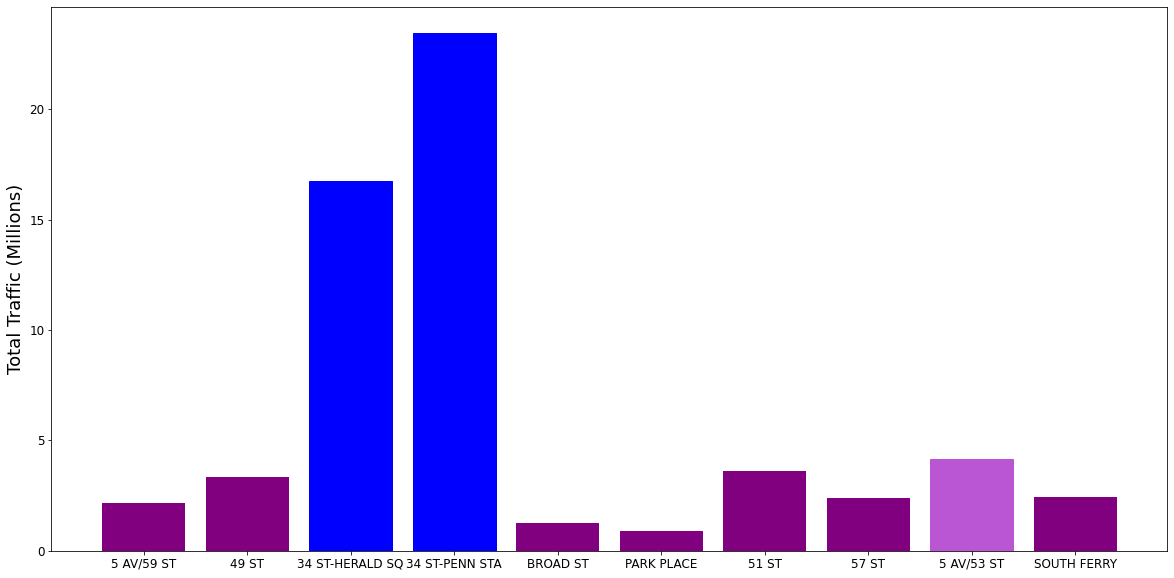

In [68]:
top_traf_inc_bar = plt.bar(top_station_income_df['STATION'], top_station_income_df['TOTAL_TRAFFIC'], color='purple')
#plt.xlabel("Stations", fontsize=18)
plt.ylabel("Total Traffic (Millions)",fontsize=18)
#plt.title("Traffic of Top 10 Stations with Highest Incomes",fontsize=27)
top_traf_inc_bar[3].set_color('b')
top_traf_inc_bar[2].set_color('b')
top_traf_inc_bar[8].set_color('mediumorchid')
plt.savefig('top10_traf_inc_bar.png', dpi=300)

In [45]:
#find max and min of lat and long
BBox = (station_lat_long_df.Longitude.min(),   station_lat_long_df.Longitude.max(),      
         station_lat_long_df.Latitude.min(), station_lat_long_df.Latitude.max())
BBox

(-74.074835, -73.761353, 40.576312, 40.898379)

In [ ]:
cd - 

In [ ]:
ruh_m = plt.imread('NYC_Map.png') #load NYC Map

In [ ]:
fig, ax = plt.subplots(figsize = (11,10))
ax.scatter(station_lat_long_df.Longitude, station_lat_long_df.Latitude, zorder=1, alpha= 0.2, c='b', s=15)
ax.set_title('Plotting Stations in NYC')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')